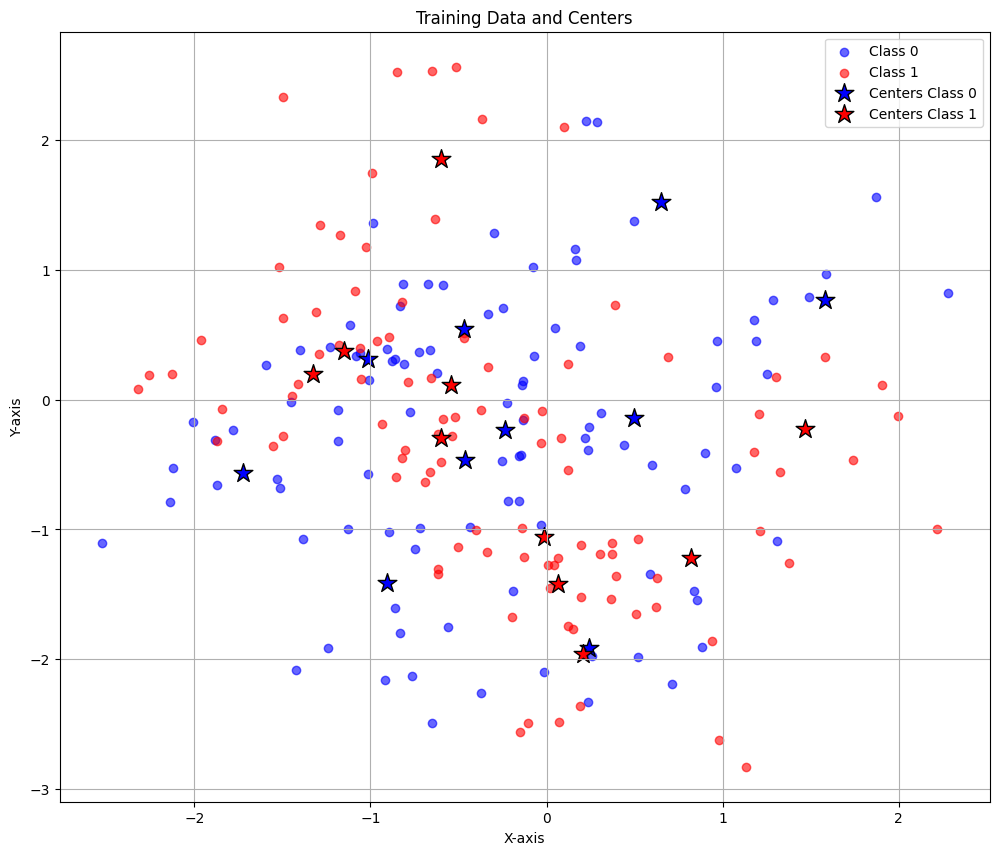

Number of centers in Class 0: 10
Number of centers in Class 1: 10
Training samples in Class 0: 100
Training samples in Class 1: 100
Test samples in Class 0: 5000
Test samples in Class 1: 5000


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Constants
NUM_CLASSES = 2
CENTERS_PER_CLASS = 10
S2 = 1/5
TRAIN_SAMPLES_PER_CLASS = 100
TEST_SAMPLES_PER_CLASS = 5000

def generate_centers(mean=[0, 0], cov=[[1, 0], [0, 1]], total_centers=20):
    """
    Generates a specified number of 2D Gaussian centers.
    """
    centers = np.random.multivariate_normal(mean=mean, cov=cov, size=total_centers)
    centers_class0 = centers[:CENTERS_PER_CLASS]
    centers_class1 = centers[CENTERS_PER_CLASS:]
    return centers_class0, centers_class1

def generate_data(class_centers, n_samples, s2=S2):
    """
    Generates data samples for a specific class using the provided centers.
    
    Parameters:
    - class_centers: np.ndarray of shape (CENTERS_PER_CLASS, 2)
    - n_samples: int, number of samples to generate
    - s2: float, variance of the Gaussian noise
    
    Returns:
    - samples: np.ndarray of shape (n_samples, 2)
    - labels: np.ndarray of shape (n_samples,)
    """
    # Randomly choose centers for each sample
    chosen_indices = np.random.randint(0, CENTERS_PER_CLASS, size=n_samples)
    selected_centers = class_centers[chosen_indices]
    
    # Generate samples from the selected centers
    noise = np.random.multivariate_normal(mean=[0, 0], cov=s2 * np.eye(2), size=n_samples)
    samples = selected_centers + noise
    
    # Assign labels based on the class
    # Assuming class_label is known externally
    return samples

# Generate 20 centers and split into two classes
centers_class0, centers_class1 = generate_centers()

# Generate training data
train_samples_class0 = generate_data(centers_class0, TRAIN_SAMPLES_PER_CLASS)
train_samples_class1 = generate_data(centers_class1, TRAIN_SAMPLES_PER_CLASS)

# Generate test data
test_samples_class0 = generate_data(centers_class0, TEST_SAMPLES_PER_CLASS)
test_samples_class1 = generate_data(centers_class1, TEST_SAMPLES_PER_CLASS)

# Create labels
train_labels_class0 = np.zeros(TRAIN_SAMPLES_PER_CLASS, dtype=int)
train_labels_class1 = np.ones(TRAIN_SAMPLES_PER_CLASS, dtype=int)
test_labels_class0 = np.zeros(TEST_SAMPLES_PER_CLASS, dtype=int)
test_labels_class1 = np.ones(TEST_SAMPLES_PER_CLASS, dtype=int)

# Combine training data
train_samples = np.vstack((train_samples_class0, train_samples_class1))
train_labels = np.concatenate((train_labels_class0, train_labels_class1))

# Combine test data
test_samples = np.vstack((test_samples_class0, test_samples_class1))
test_labels = np.concatenate((test_labels_class0, test_labels_class1))

# Plotting
plt.figure(figsize=(12, 10))

# Plot training samples
plt.scatter(train_samples_class0[:, 0], train_samples_class0[:, 1],
            c='blue', alpha=0.6, label='Class 0')
plt.scatter(train_samples_class1[:, 0], train_samples_class1[:, 1],
            c='red', alpha=0.6, label='Class 1')

# Overlay centers
plt.scatter(centers_class0[:, 0], centers_class0[:, 1],
            c='blue', marker='*', s=200, edgecolors='k', label='Centers Class 0')
plt.scatter(centers_class1[:, 0], centers_class1[:, 1],
            c='red', marker='*', s=200, edgecolors='k', label='Centers Class 1')

plt.title('Training Data and Centers')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

# Print summary
print(f"Number of centers in Class 0: {len(centers_class0)}")
print(f"Number of centers in Class 1: {len(centers_class1)}")
print(f"Training samples in Class 0: {train_samples_class0.shape[0]}")
print(f"Training samples in Class 1: {train_samples_class1.shape[0]}")
print(f"Test samples in Class 0: {test_samples_class0.shape[0]}")
print(f"Test samples in Class 1: {test_samples_class1.shape[0]}")


In [3]:
# Part 2
def pairwise_distances(X, Y):
    """
    Compute pairwise Euclidean distances between two sets of vectors.
    
    Parameters:
    X : numpy array of shape (n_samples_X, n_features)
    Y : numpy array of shape (n_samples_Y, n_features)
    
    Returns:
    distances : numpy array of shape (n_samples_X, n_samples_Y)
    """
    # Compute the squared Euclidean distances
    X_squared = np.sum(X**2, axis=1, keepdims=True)
    Y_squared = np.sum(Y**2, axis=1)
    XY = np.dot(X, Y.T)
    
    # Use broadcasting to compute distances
    squared_distances = X_squared + Y_squared - 2 * XY
    
    # Take the square root to get Euclidean distances
    # We use np.maximum to avoid small negative values due to floating point errors
    return np.sqrt(np.maximum(squared_distances, 0))

def knn(train_data,train_labels, test_data, k=2):
    assert(train_data.shape[0] == train_labels.shape[0])
    assert(train_data.shape[1] == test_data.shape[1])
    # Compute distances
    distances = pairwise_distances(test_data, train_data)
    assert(distances.shape == (test_data.shape[0], train_data.shape[0]))


    sorted_indices = np.argsort(distances, axis=1)[:, :k]
    assert(sorted_indices.shape == (test_data.shape[0], k))

    nearest_labels = train_labels[sorted_indices]

    # Count the number of True values (class 0) for each query point
    class_0_counts = np.sum(nearest_labels, axis=1)
    
    # If class 0 count is greater than k/2, assign class 0, otherwise class 1
    most_common_labels = (class_0_counts > k/2).astype(int)
    
    return most_common_labels

train_data = np.concatenate([train_class0, train_class1])
train_labels = np.array([0] * train_class0.shape[0] + [1] * train_class1.shape[0])
test_data = np.concatenate([test_class0, test_class1])
test_labels = np.array([0] * test_class0.shape[0] + [1] * test_class1.shape[0])

results = knn(train_data,train_labels,test_data, k=3)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# Prepare data for scikit-learn's KNN


# Use scikit-learn's KNN
knn_sklearn = KNeighborsClassifier(n_neighbors=3)
knn_sklearn.fit(train_data, train_labels)

# Predict with scikit-learn's KNN
sklearn_results = knn_sklearn.predict(test_data)

# Compare the results
print("Custom KNN Results:", results)
print("Scikit-learn KNN Results:", sklearn_results)

# Check accuracy
custom_accuracy = accuracy_score(test_labels, results)
sklearn_accuracy = accuracy_score(test_labels, sklearn_results)

print(f"Custom KNN Accuracy: {custom_accuracy}")
print(f"Scikit-learn KNN Accuracy: {sklearn_accuracy}")


Custom KNN Results: [1 0 0 ... 1 0 1]
Scikit-learn KNN Results: [1 0 0 ... 1 0 1]
Custom KNN Accuracy: 0.6343
Scikit-learn KNN Accuracy: 0.6343


In [6]:
# Part 3
# TODO: How to know if this is right
from sklearn.model_selection import cross_val_score

def sklearn_cross_validation(X, y, k_fold=10, k_range=range(1, 180)):
    k_accuracies = {}
    
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=k_fold, scoring='accuracy')
        k_accuracies[k] = scores.mean()
    
    best_k = max(k_accuracies, key=k_accuracies.get)
    best_accuracy = k_accuracies[best_k]
    
    return best_k, best_accuracy, k_accuracies

def cross_validation(X,y, k_fold = 10, k_range = range(1,180)):
    n = len(X)
    fold_size = n // k_fold
    k_accuracies = {}
    
    for k in k_range:
        accuracy = 0
        for i in range(k_fold):
            start = i * fold_size
            end = (i+1) * fold_size
            X_train = np.concatenate([X[:start], X[end:]])
            y_train = np.concatenate([y[:start], y[end:]])
            X_val = X[start:end]
            y_val = y[start:end]
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)
            accuracy += accuracy_score(y_val, y_pred)
        k_accuracies[k] = accuracy / k_fold

    best_k = max(k_accuracies, key=k_accuracies.get)
    best_accuracy = k_accuracies[best_k]

    return best_k, best_accuracy, k_accuracies
accuracies = cross_validation(train_data, train_labels)
reference_accuracies = sklearn_cross_validation(train_data, train_labels)
print(accuracies)
print(reference_accuracies)



(6, 0.64, {1: 0.5449999999999999, 2: 0.5700000000000001, 3: 0.6150000000000001, 4: 0.6199999999999999, 5: 0.595, 6: 0.64, 7: 0.6149999999999999, 8: 0.635, 9: 0.61, 10: 0.6149999999999999, 11: 0.575, 12: 0.5700000000000001, 13: 0.565, 14: 0.575, 15: 0.525, 16: 0.53, 17: 0.515, 18: 0.5200000000000001, 19: 0.53, 20: 0.5349999999999999, 21: 0.54, 22: 0.525, 23: 0.53, 24: 0.52, 25: 0.5200000000000001, 26: 0.5, 27: 0.48999999999999994, 28: 0.5000000000000001, 29: 0.48999999999999994, 30: 0.505, 31: 0.475, 32: 0.5, 33: 0.495, 34: 0.505, 35: 0.48999999999999994, 36: 0.48999999999999994, 37: 0.485, 38: 0.46499999999999997, 39: 0.45, 40: 0.45499999999999996, 41: 0.44000000000000006, 42: 0.43499999999999994, 43: 0.42000000000000004, 44: 0.45000000000000007, 45: 0.44000000000000006, 46: 0.44499999999999995, 47: 0.43499999999999994, 48: 0.43999999999999995, 49: 0.4149999999999999, 50: 0.43, 51: 0.39999999999999997, 52: 0.43, 53: 0.41, 54: 0.425, 55: 0.395, 56: 0.41500000000000004, 57: 0.385, 58: 0.

In [9]:
# Part 4
def bayes_rule(X_test, centers, s2):
    n_samples, n_features = X_test.shape
    n_centers = centers.shape[0] // 2  # Assuming equal centers for each class
    
    # Reshape centers for broadcasting
    centers_reshaped = centers.reshape(2, n_centers, n_features)
    
    # Calculate squared Euclidean distances
    distances = np.sum((X_test[:, np.newaxis, np.newaxis, :] - centers_reshaped[np.newaxis, :, :, :]) ** 2, axis=3)
    
    # Calculate exponential terms
    exp_terms = np.exp(-distances / (2 * s2))
    
    # Sum over centers for each class
    class_probs = np.sum(exp_terms, axis=2)
    
    # Calculate the ratio
    ratio = class_probs[:, 1] / class_probs[:, 0]
    
    # Make predictions
    predictions = (ratio >= 1).astype(int)
    
    return predictions

# Test the function
y_pred = bayes_rule(test_data, centers, 1/5)
conf_matrix = np.zeros((2, 2), dtype=int)
conf_matrix[0, 0] = np.sum((test_labels == 0) & (y_pred == 0))  # True Negatives
conf_matrix[0, 1] = np.sum((test_labels == 0) & (y_pred == 1))  # False Positives
conf_matrix[1, 0] = np.sum((test_labels == 1) & (y_pred == 0))  # False Negatives
conf_matrix[1, 1] = np.sum((test_labels == 1) & (y_pred == 1))  # True Positives

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[3319 1681]
 [1242 3758]]


/var/folders/fc/z903c2bn73s9_l02mz68j63h0000gn/T/ipykernel_69061/2298273106.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([errors_knn7, errors_knn_cv, errors_bayes], labels=['kNN (K=7)', 'kNN (CV)', 'Bayes Rule'])


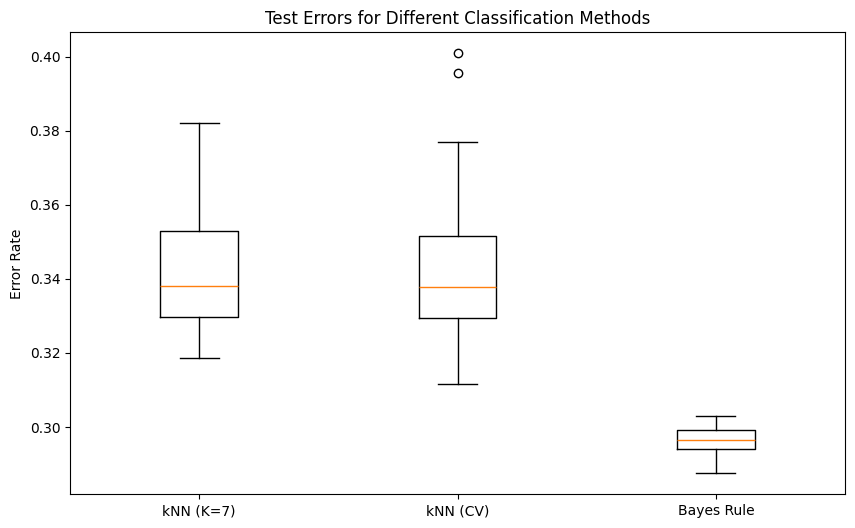

Five-number summary for selected K values:
Min: 1.0, 25%: 8.25, Median: 11.5, 75%: 16.75, Max: 54.0


In [16]:
# Part 5
# Simulation study
n_simulations = 50
errors_knn7 = []
errors_knn_cv = []
errors_bayes = []
selected_k_values = []

for _ in range(n_simulations):
    # Generate training and test data
    X_train, y_train = generate_data(centers, 200)
    X_test, y_test = generate_data(centers, 10000)
    
    # kNN with K=7
    knn7 = KNeighborsClassifier(n_neighbors=7)
    knn7.fit(X_train, y_train)
    y_pred_knn7 = knn7.predict(X_test)
    errors_knn7.append(1 - accuracy_score(y_test, y_pred_knn7))
    
    # kNN with CV-selected K
    best_k, _, _ = cross_validation(X_train, y_train)
    selected_k_values.append(best_k)
    knn_cv_best = KNeighborsClassifier(n_neighbors=best_k)
    knn_cv_best.fit(X_train, y_train)
    y_pred_knn_cv = knn_cv_best.predict(X_test)
    errors_knn_cv.append(1 - accuracy_score(y_test, y_pred_knn_cv))
    
    # Bayes rule
    y_pred_bayes = bayes_rule(X_test, centers, 1/5)
    errors_bayes.append(1 - accuracy_score(y_test, y_pred_bayes))

# Create box plot
plt.figure(figsize=(10, 6))
plt.boxplot([errors_knn7, errors_knn_cv, errors_bayes], labels=['kNN (K=7)', 'kNN (CV)', 'Bayes Rule'])
plt.title('Test Errors for Different Classification Methods')
plt.ylabel('Error Rate')
plt.show()

# Calculate five-number summary for selected K values
k_summary = np.percentile(selected_k_values, [0, 25, 50, 75, 100])
print("Five-number summary for selected K values:")
print(f"Min: {k_summary[0]}, 25%: {k_summary[1]}, Median: {k_summary[2]}, 75%: {k_summary[3]}, Max: {k_summary[4]}")